In [62]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [63]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [64]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [65]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [66]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [167]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

# Opt 

In [168]:
volume = Volume(get_layers())
dets = volume.get_detectors()
opt = torch.optim.SGD(volume.parameters(), lr=2e-3)
mu = MuonBatch(generate_batch(100), init_z=1)
volume(mu)
scatters = ScatterBatch(mu, volume)

In [69]:
from torch.distributions import Normal

In [70]:
loc_unc = 0.1*torch.ones(10,3)

In [71]:
dists = {}
for i, d in enumerate(['x','y','z']):
    dists[d] = Normal(0.5+torch.zeros(len(loc_unc)), loc_unc[:,i])

In [72]:
lower = 0.1*Tensor(np.mgrid[2:8:1, 0:10:1, 0:10:1,].reshape(3,-1).transpose(-1,-2))
lower.shape

torch.Size([600, 3])

In [73]:
lower.shape

torch.Size([600, 3])

In [74]:
def comp_int(low, high):
    return torch.prod(torch.stack([dists[d].cdf(high[i])-dists[d].cdf(low[i]) for i,d in enumerate(dists)]), dim=0)

In [75]:
prob = torch.stack([comp_int(l, l+0.1) for l in lower.unbind()])

In [76]:
prob = prob.transpose(-1,-2).reshape(len(loc_unc),6,10,10)

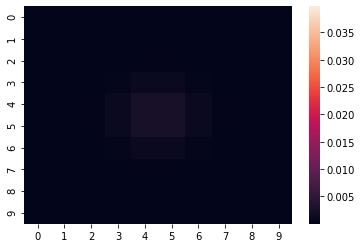

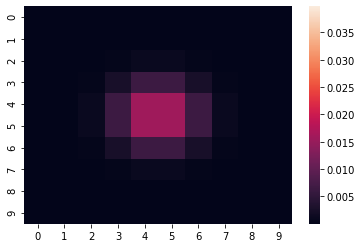

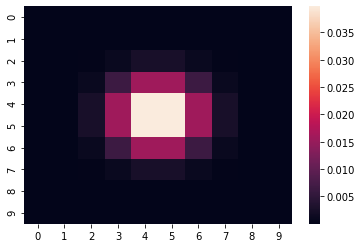

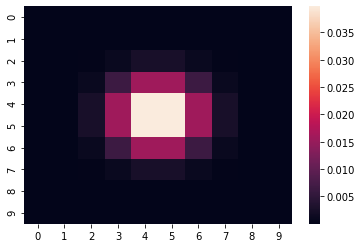

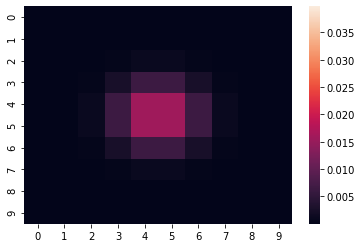

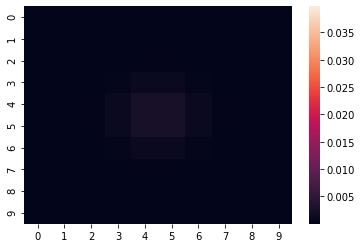

In [77]:
for l in range(6):
    sns.heatmap(prob[0,l,:,:], vmax=prob.max(), vmin=prob.min())
    plt.show()

In [78]:
from torch._vmap_internals import _vmap as vmap

In [79]:
def comp_int(low):
    return torch.prod(torch.stack([dists[d].cdf(low[i]+0.1)-dists[d].cdf(low[i]) for i,d in enumerate(dists)]), dim=0)

In [80]:
comp_int(lower[0])

tensor([2.1075e-11, 2.1075e-11, 2.1075e-11, 2.1075e-11, 2.1075e-11, 2.1075e-11,
        2.1075e-11, 2.1075e-11, 2.1075e-11, 2.1075e-11])

vmap(comp_int)(lower)

In [82]:
lower.shape

torch.Size([600, 3])

In [83]:
class GaussianX0Inferer(X0Inferer):
    def average_preds(
        self, x0_dtheta: Optional[Tensor], x0_dtheta_unc: Optional[Tensor], x0_dxy: Optional[Tensor], x0_dxy_unc: Optional[Tensor], efficiency: Tensor
    ) -> Tuple[Tensor, Tensor]:
        r"""
        TODO: Implement differing x0 accoring to location via Gaussian spread
        TODO: Don't assume that location uncertainties are uncorrelated
        """

        loc, loc_unc = self.scatters.location[self.mask], self.scatters.location_unc[self.mask]  # loc is (x,y,z)
        shp_xyz = len(loc), round(volume.lw.numpy()[0] / volume.size), round(volume.lw.numpy()[1] / volume.size), len(self.volume.get_passives())
        shp_zxy = shp_xyz[0], shp_xyz[3], shp_xyz[1], shp_xyz[2]
        int_bounds = self.volume.size*np.mgrid[0:round(self.volume.lw.numpy()[0]/self.volume.size):1,
                                               0:round(self.volume.lw.numpy()[1]/self.volume.size):1,
                                               round(self.volume.get_passive_z_range()[0].numpy()[0]/self.volume.size):round(self.volume.get_passive_z_range()[1].numpy()[0]/self.volume.size):1]
        int_bounds[2] = np.flip(int_bounds[2])  # z is reversed
        int_bounds = Tensor(int_bounds.reshape(3,-1).transpose(-1,-2))

        wpreds, weights = [], []
        for x0, unc in ((x0_dtheta, x0_dtheta_unc), (x0_dxy, x0_dxy_unc)):
            if x0 is None or unc is None:
                continue
            x0 = x0[:,None,None,None].expand(shp_zxy).clone()
            coef = efficiency[:,None,None,None].expand(shp_zxy).clone() / ((1e-17) + (unc[:,None,None,None].expand(shp_zxy).clone() ** 2))
            
            # Gaussian spread
            dists = {}
            for i, d in enumerate(['x','y','z']):
                dists[d] = Normal(loc[:,i], loc_unc[:,i]+1e-7)  # location uncertainty is sometimes zero, causing errors
            
            def comp_int(low:Tensor, high:Tensor, dists:Dict[str, Tensor]) -> Tensor:
                return torch.prod(torch.stack([dists[d].cdf(high[i])-dists[d].cdf(low[i]) for i,d in enumerate(dists)]), dim=0)
            
            prob = torch.stack([comp_int(l, l+self.volume.size, dists) for l in int_bounds.unbind()]).transpose(-1,-2).reshape(shp_xyz).permute(0,3,1,2)  # preds are (z,x,y)  TODO: vmap this
            coef = coef*prob
            
            wpreds.append(x0*coef)
            weights.append(coef)

        wpred, weight = torch.cat(wpreds, dim=0), torch.cat(weights, dim=0)
        wpred, weight = wpred.sum(0), weight.sum(0)
        pred = wpred / weight

        return pred, weight

In [84]:
lower = volume.size*np.mgrid[round(volume.get_passive_z_range()[0].numpy()[0]/volume.size):round(volume.get_passive_z_range()[1].numpy()[0]/volume.size):1,
                                                      0:round(volume.lw.numpy()[0]/volume.size):1,
                                                      0:round(volume.lw.numpy()[1]/volume.size):1]
lower[0] = np.flip(lower[0])

In [85]:
lower.reshape(3,-1).transpose(-1,-2)

array([[0.7, 0. , 0. ],
       [0.7, 0. , 0.1],
       [0.7, 0. , 0.2],
       ...,
       [0.2, 0.9, 0.7],
       [0.2, 0.9, 0.8],
       [0.2, 0.9, 0.9]])

In [86]:
loc_unc[1]

tensor([0.1000, 0.1000, 0.1000])

In [87]:
x0, unc = X0Inferer(scatters).x0_from_dtheta()

efficiency = torch.ones_like(x0)
mask = scatters.get_scatter_mask()
loc, loc_unc = scatters.location[mask], scatters.location_unc[mask]
# loc = torch.zeros_like(loc)
# loc_unc = torch.ones_like(loc_unc)*0.1
# loc[0] = 1
# loc[0,2] = 0.5

shp = len(loc), len(volume.get_passives()), round(volume.lw.numpy()[0] / volume.size), round(volume.lw.numpy()[1] / volume.size)
int_bounds = volume.size*np.mgrid[0:10:1, 0:10:1, 2:8:1]
int_bounds[2] = np.flip(int_bounds[2])  # z is reversed
int_bounds = Tensor(int_bounds.reshape(3,-1).transpose(-1,-2))

# Gaussian spread
dists = {}
for i, d in enumerate(['x','y','z']):
    dists[d] = Normal(loc[:,i], loc_unc[:,i])

def comp_int(low:Tensor, high:Tensor, dists:Dict[str, Tensor]) -> Tensor:
    return torch.prod(torch.stack([dists[d].cdf(high[i])-dists[d].cdf(low[i]) for i,d in enumerate(dists)]), dim=0)

prob = torch.stack([comp_int(l, l+volume.size, dists) for l in int_bounds.unbind()]).transpose(-1,-2).reshape(len(loc_unc),10,10,6).permute(0,3,1,2)

tensor([0.5767, 0.2021, 0.3624], grad_fn=<SelectBackward>) tensor([0.0141, 0.0186, 0.2184], grad_fn=<SelectBackward>)


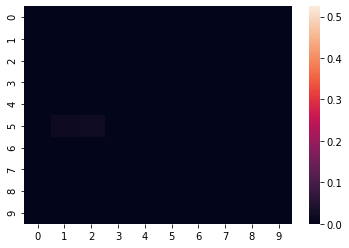

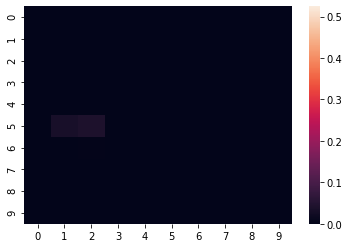

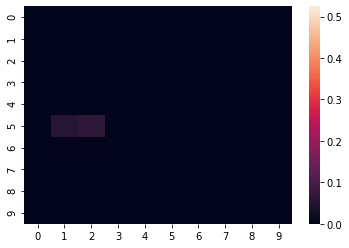

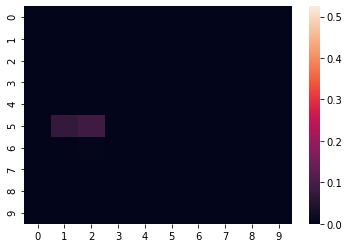

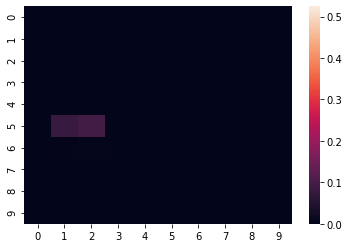

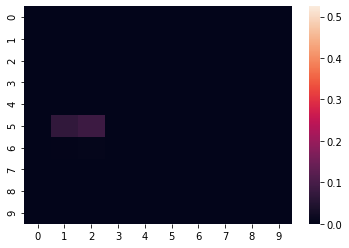

In [88]:
i = 4
print(loc[i], loc_unc[i])
for l in range(6):
    sns.heatmap(prob[i,l,:,:].detach().numpy(), vmax=prob.max(), vmin=prob.min())
    plt.show()

In [169]:
x0_gaussian_inferer = GaussianX0Inferer(scatters=scatters)

In [170]:
x0_inferer = X0Inferer(scatters=scatters, use_gaussian_spread=False)

In [171]:
pred_g, weight_g = x0_gaussian_inferer.pred_x0(True)

In [172]:
pred, weight = x0_inferer.pred_x0(True)

In [173]:
for l in volume.get_detectors():
    print(torch.autograd.grad(pred_g.abs().sum(), l.resolution, retain_graph=True, allow_unused=True)[0])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  8.4004e-08,  0.0000e+00, -2.9593e-08,  0.0000e+00],
        [ 6.7923e-06,  0.0000e+00,  1.9182e-06,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0020e-05,  2.9245e-06, -2.6480e-07,  0.0000e+00,
          2.8463e-07,  4.0822e-07,  3.6331e-06,  4.2873e-06,  0.0000e+00],
        [ 3.7715e-07,  1.1062e-06,  0.0000e+00,  1.5001e-06,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.7361e-07,  7.7818e-07],
        [ 0.0000e+00, -2.6975e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          9.5369e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0099e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.7706e-07,  0.0000e+00,  5.5001e-07,  0.0000e+00,  2.8642e-07],
        [ 0.0000e+00,  3.4859e-07,  0.0000e+00,  5.4359e-08,  8.6767e-07,
          0.0000e+00,  5.0567e-0

In [174]:
for l in volume.get_detectors():
    print(torch.autograd.grad(pred.abs().sum(), l.resolution, retain_graph=True, allow_unused=True)[0])

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  8.4004e-08,  0.0000e+00, -2.9593e-08,  0.0000e+00],
        [ 6.7923e-06,  0.0000e+00,  1.9182e-06,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.0020e-05,  2.9245e-06, -2.6480e-07,  0.0000e+00,
          2.8463e-07,  4.0822e-07,  3.6331e-06,  4.2873e-06,  0.0000e+00],
        [ 3.7715e-07,  1.1062e-06,  0.0000e+00,  1.5001e-06,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  1.7361e-07,  7.7818e-07],
        [ 0.0000e+00, -2.6975e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          9.5369e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0099e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.7706e-07,  0.0000e+00,  5.5001e-07,  0.0000e+00,  2.8642e-07],
        [ 0.0000e+00,  3.4859e-07,  0.0000e+00,  5.4359e-08,  8.6767e-07,
          0.0000e+00,  5.0567e-0

In [139]:
pred_g.abs().sum()

tensor(0.0099, grad_fn=<SumBackward0>)

In [92]:
pred, weight = x0_inferer.pred_x0(False)

In [93]:
pred_g.shape

torch.Size([6, 10, 10])

In [94]:
weight_g.shape

torch.Size([6, 10, 10])

In [95]:
pred_g[pred == pred].mean()

tensor(0.0008, grad_fn=<MeanBackward0>)

In [96]:
pred[pred == pred].mean()

tensor(0.0008, grad_fn=<MeanBackward0>)

In [ ]:
from fastprogress import progress_bar

In [218]:
wpreds_g, weights_g, wpreds, weights = [], [], [], []
muon_bar = progress_bar(range(1000 // 100))
for _ in muon_bar:
    mu = MuonBatch(generate_batch(100), init_z=1)
    volume(mu)
    sb = ScatterBatch(mu, volume)
    p, w = X0Inferer(sb).pred_x0(inc_default=False)
    p = torch.nan_to_num(p)
    wpreds.append(p * w)
    weights.append(w)
    p, w = GaussianX0Inferer(sb).pred_x0(inc_default=False)
    p = torch.nan_to_num(p)
    wpreds_g.append(p * w)
    weights_g.append(w)

weight = torch.stack(weights, dim=0).sum(0)
pred = torch.stack(wpreds, dim=0).sum(0) / weight
weight_g = torch.stack(weights_g, dim=0).sum(0)
pred_g = torch.stack(wpreds_g, dim=0).sum(0) / weight_g

In [219]:
true = volume.get_rad_cube()

In [220]:
from tomopt.plotting import plot_pred_true_x0

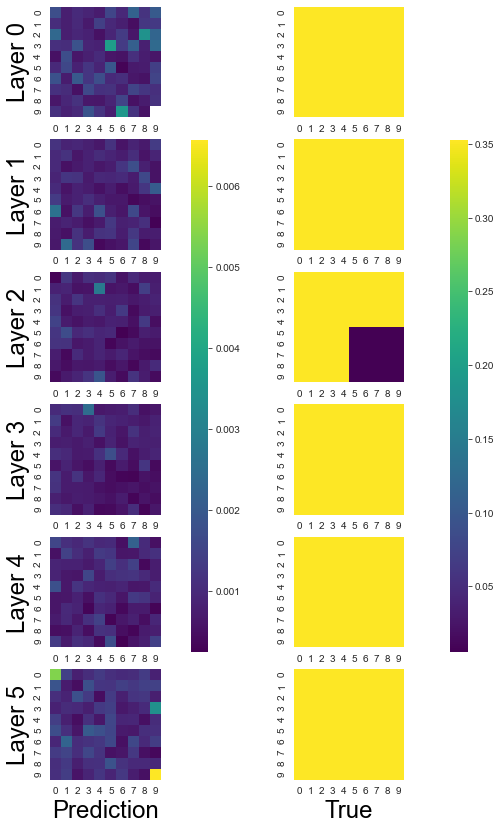

In [221]:
plot_pred_true_x0(pred.detach().numpy(), true)

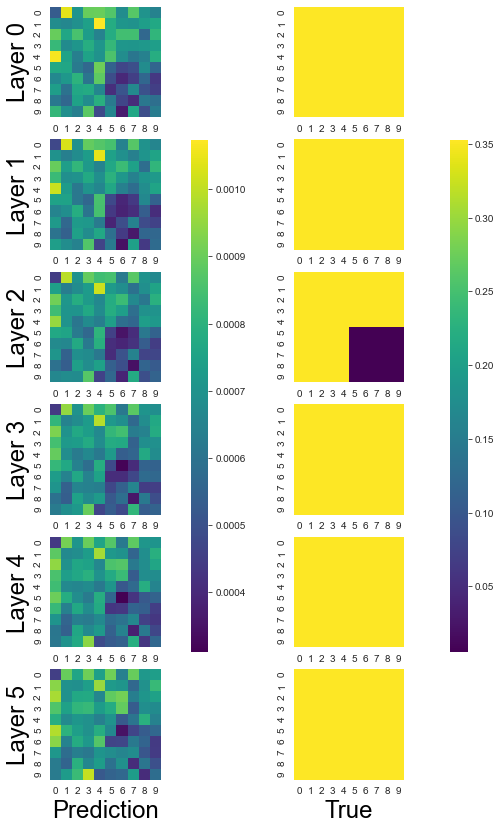

In [222]:
plot_pred_true_x0(pred_g.detach().numpy(), true)

# 100k image

In [234]:
wpreds_g, weights_g, wpreds, weights = [], [], [], []
muon_bar = progress_bar(range(100000 // 100))
for _ in muon_bar:
    mu = MuonBatch(generate_batch(100), init_z=1)
    volume(mu)
    sb = ScatterBatch(mu, volume)
    p, w = X0Inferer(sb).pred_x0(inc_default=False)
    p = torch.nan_to_num(p)
    wpreds.append(p * w)
    weights.append(w)
    p, w = GaussianX0Inferer(sb).pred_x0(inc_default=False)
    p = torch.nan_to_num(p)
    wpreds_g.append(p * w)
    weights_g.append(w)

weight = torch.stack(weights, dim=0).sum(0)
pred = torch.stack(wpreds, dim=0).sum(0) / weight
weight_g = torch.stack(weights_g, dim=0).sum(0)
pred_g = torch.stack(wpreds_g, dim=0).sum(0) / weight_g

In [235]:
true = volume.get_rad_cube()

In [236]:
from tomopt.plotting import plot_pred_true_x0

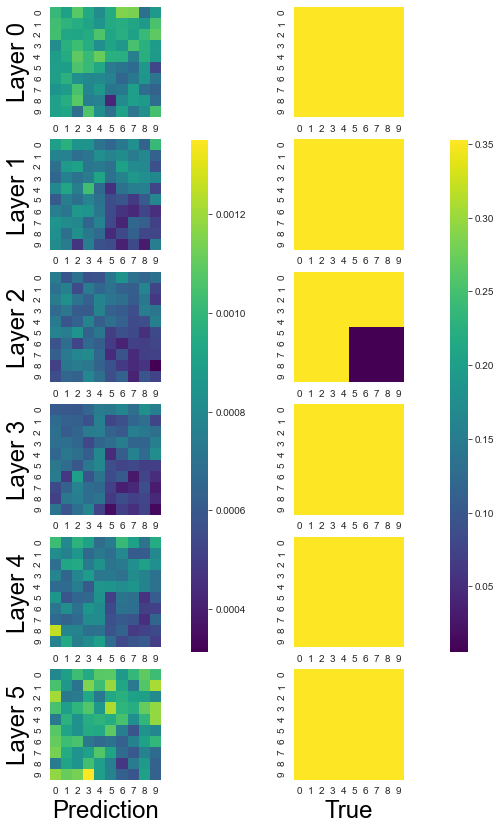

In [237]:
plot_pred_true_x0(pred.detach().numpy(), true)

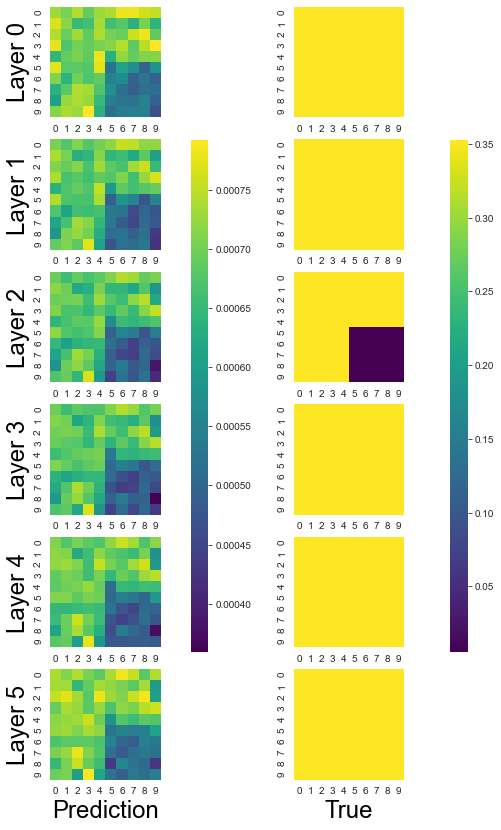

In [238]:
plot_pred_true_x0(pred_g.detach().numpy(), true)